In [1]:
import pandas as pd
from scipy import stats
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
from datetime import datetime
import random

import sys

from dateutil.parser import parse
from matplotlib import dates

from sklearn import preprocessing, neighbors, linear_model, model_selection, ensemble

In [2]:
d = pd.read_csv('../data/2016_subset_all_tables.csv', index_col = 0)

In [3]:
d.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,dcoilwtico,city,state,type,cluster,transactions,holitype
id,,,,,,,,,,,,,,,
71278985,2016-02-22,6,1464027,3.0,False,BEVERAGES,1148,0,31.37,Quito,Pichincha,D,13,1630,No_Holiday
82077989,2016-06-14,6,1913600,1.0,False,PERSONAL CARE,4118,0,48.49,Quito,Pichincha,D,13,1603,No_Holiday
92852321,2016-10-04,6,881701,2.0,False,GROCERY I,1042,0,48.67,Quito,Pichincha,D,13,1605,No_Holiday
72713582,2016-03-08,6,1150954,2.0,False,BEVERAGES,1124,0,36.67,Quito,Pichincha,D,13,1732,No_Holiday
72714342,2016-03-08,6,1898960,5.0,False,BEVERAGES,1126,0,36.67,Quito,Pichincha,D,13,1732,No_Holiday


In [4]:
d['date_as_datetime'] = [parse(x) for x in d['date']]
d['date_as_num'] = [dates.date2num(x) for x in d['date_as_datetime']]

In [5]:
d.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,dcoilwtico,city,state,type,cluster,transactions,holitype,date_as_datetime,date_as_num
id,,,,,,,,,,,,,,,,,
71278985,2016-02-22,6,1464027,3.0,False,BEVERAGES,1148,0,31.37,Quito,Pichincha,D,13,1630,No_Holiday,2016-02-22,736016.0
82077989,2016-06-14,6,1913600,1.0,False,PERSONAL CARE,4118,0,48.49,Quito,Pichincha,D,13,1603,No_Holiday,2016-06-14,736129.0
92852321,2016-10-04,6,881701,2.0,False,GROCERY I,1042,0,48.67,Quito,Pichincha,D,13,1605,No_Holiday,2016-10-04,736241.0
72713582,2016-03-08,6,1150954,2.0,False,BEVERAGES,1124,0,36.67,Quito,Pichincha,D,13,1732,No_Holiday,2016-03-08,736031.0
72714342,2016-03-08,6,1898960,5.0,False,BEVERAGES,1126,0,36.67,Quito,Pichincha,D,13,1732,No_Holiday,2016-03-08,736031.0


In [6]:
d = d.join(pd.get_dummies(d['family'], prefix = 'family'))
d = d.join(pd.get_dummies(d['type'], prefix = 'type'))
d = d.join(pd.get_dummies(d['city'], prefix = 'city'))
d = d.join(pd.get_dummies(d['holitype'], prefix = 'holitype'))

In [7]:
d = d.dropna()

In [8]:
v_train, v_test = model_selection.train_test_split(d, test_size = 0.25)

In [9]:
v_train_cols = ['onpromotion', 'perishable', 'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 'type_A',
       'type_B', 'type_C', 'type_D', 'type_E', 'city_Ambato', 'city_Babahoyo',
       'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen',
       'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra',
       'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala',
       'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito',
       'city_Riobamba', 'city_Salinas', 'city_Santo Domingo',
       'holitype_Additional', 'holitype_Bridge', 'holitype_Event',
       'holitype_Holiday', 'holitype_No_Holiday', 'holitype_Transfer']

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])

print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
all_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0830482434599


In [10]:
knn = neighbors.KNeighborsRegressor()

knn_param_grid = [
    {'n_neighbors': range(1,200, 10)}
]

knn_grid = model_selection.GridSearchCV(knn, param_grid = knn_param_grid)
knn_grid.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(knn_grid.cv_results_['split0_test_score'])
print(knn_grid.cv_results_['split1_test_score'])
print(knn_grid.cv_results_['split2_test_score'])

[-0.26463578 -0.00527043  0.02164778  0.02008727  0.02057227  0.02249693
  0.02251843  0.02346469  0.02168145  0.02310911  0.02279956  0.02160564
  0.02010944  0.01961292  0.01873751  0.0204185   0.02050087  0.02028632
  0.01984919  0.01937421]
[-0.60688112 -0.17519369 -0.08995069 -0.08017692 -0.0483586  -0.03186336
 -0.01420613  0.01114866  0.01598922  0.02361176  0.02918425  0.0365603
  0.04202936  0.04384746  0.04371715  0.04389289  0.04394974  0.04242702
  0.04335093  0.04356521]
[-0.49261903 -0.08794891 -0.09170457 -0.04716902 -0.03862553 -0.04549828
 -0.03994586 -0.03629119 -0.02485951 -0.01789678 -0.01475975 -0.00919263
 -0.00511407 -0.00300994  0.00059147  0.00250105  0.00496083  0.00702007
  0.00791991  0.00796248]


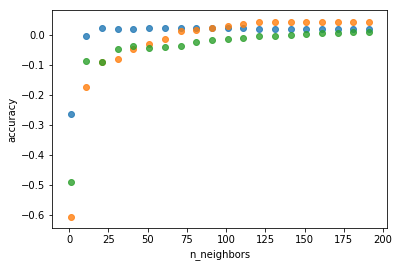

In [11]:

sp0 = sns.regplot(np.array(range(1, 200, 10)), knn_grid.cv_results_['split0_test_score'], fit_reg = False, label = 'split0').set(xlabel = 'n_neighbors', ylabel = 'accuracy')
sp1 = sns.regplot(np.array(range(1, 200, 10)), knn_grid.cv_results_['split1_test_score'], fit_reg = False, label = 'split1')
sp2 = sns.regplot(np.array(range(1, 200, 10)), knn_grid.cv_results_['split2_test_score'], fit_reg = False, label = 'split2')

plt.show()


In [12]:
knn_200 = neighbors.KNeighborsRegressor(n_neighbors = 200)
knn_200.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])
knn_200.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.018612293181824224

In [13]:
rf = ensemble.RandomForestRegressor()
rf.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])
rf.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


-0.22463897029355848

In [14]:
#ugghhhh the huge number of one-hot columns is causing me troubles!
#maybe it's time to switch to H2O!

#for now linear regression is performing best, but lets see if it needs the categorical stuff

v_train_cols = ['onpromotion', 'perishable', 'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 
        'type_A',
       'type_B', 'type_C', 'type_D', 'type_E', 
   #     'city_Ambato', 'city_Babahoyo',
    #   'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen',
     #  'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra',
     #  'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala',
      # 'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito',
       #'city_Riobamba', 'city_Salinas', 'city_Santo Domingo',
       'holitype_Additional', 'holitype_Bridge', 'holitype_Event',
       'holitype_Holiday', 'holitype_No_Holiday', 'holitype_Transfer']

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_city_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0869588407391


In [15]:
#for now linear regression is performing best, but lets see if it needs the categorical stuff

v_train_cols = ['onpromotion', 'perishable', 'dcoilwtico',
       'transactions',
     #  'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
     #  'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
     #  'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
     #  'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
     #  'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
     #  'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
     #  'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
     #  'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
     #  'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
     #  'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
     #  'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 
        'type_A',
       'type_B', 'type_C', 'type_D', 'type_E', 
        'city_Ambato', 'city_Babahoyo',
       'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen',
      'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra',
       'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala',
       'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito',
       'city_Riobamba', 'city_Salinas', 'city_Santo Domingo',
       'holitype_Additional', 'holitype_Bridge', 'holitype_Event',
       'holitype_Holiday', 'holitype_No_Holiday', 'holitype_Transfer']

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_family_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0407147840762


In [16]:
#for now linear regression is performing best, but lets see if it needs the categorical stuff

v_train_cols = ['onpromotion', 'perishable', 'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 
    #    'type_A',
    #   'type_B', 'type_C', 'type_D', 'type_E', 
        'city_Ambato', 'city_Babahoyo',
       'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen',
       'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra',
       'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala',
       'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito',
       'city_Riobamba', 'city_Salinas', 'city_Santo Domingo',
       'holitype_Additional', 'holitype_Bridge', 'holitype_Event',
       'holitype_Holiday', 'holitype_No_Holiday', 'holitype_Transfer']

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_type_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0839249247992


In [17]:
#for now linear regression is performing best, but lets see if it needs the categorical stuff

v_train_cols = ['onpromotion', 'perishable', 'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 
        'type_A',
       'type_B', 'type_C', 'type_D', 'type_E', 
        'city_Ambato', 'city_Babahoyo',
       'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen',
      'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra',
       'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala',
       'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito',
       'city_Riobamba', 'city_Salinas', 'city_Santo Domingo'
       #         ,
      # 'holitype_Additional', 'holitype_Bridge', 'holitype_Event',
     #  'holitype_Holiday', 'holitype_No_Holiday', 'holitype_Transfer'
               ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_holi_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0887826323023


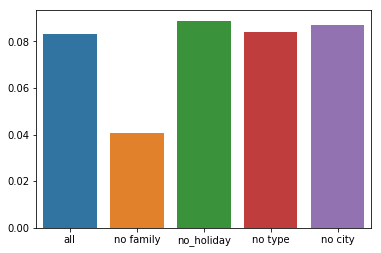

In [18]:
sns.barplot(['all', 'no family', 'no_holiday', 'no type', 'no city'], 
            [all_lin, no_family_lin, no_holi_lin, no_type_lin, no_city_lin])

In [19]:
v_train_cols = [
        'onpromotion', 
        'perishable', 
        'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD' 
        ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
fam_all_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0930635214758


In [20]:
v_train_cols = [
        'onpromotion', 
        'perishable', 
        #'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD' 
        ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_oil_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0930573296829


In [21]:
v_train_cols = [
        'onpromotion', 
        #'perishable', 
        'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD' 
        ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_perish_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0930399447462


In [22]:
v_train_cols = [
        #'onpromotion', 
        'perishable', 
        'dcoilwtico',
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD' 
        ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_promo_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

-8.88135097834e+14


In [23]:
v_train_cols = [
        'onpromotion', 
        'perishable', 
        'dcoilwtico',
       #'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD' 
        ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
no_trans_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

-2.8807606171e+18


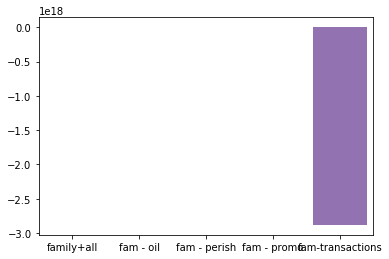

In [24]:
sns.barplot(['family+all', 'fam - oil', 'fam - perish', 'fam - promo', 'fam-transactions'], 
            [fam_all_lin, no_oil_lin, no_perish_lin, no_promo_lin, no_trans_lin])

In [25]:
v_train_cols = [
        'onpromotion', 
       'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD' 
        ]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(v_train.loc[:, v_train_cols], v_train.loc[:, ['unit_sales']])


print(lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']]))
promo_trans_fam_lin = lin_reg.score(v_test.loc[:,v_train_cols], v_test.loc[:, ['unit_sales']])

0.0930337438807


In [26]:
test = dd.read_csv('../data/raw/test.csv')
test.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [27]:
items = dd.read_csv('../data/raw/' + 'items.csv')
stores = dd.read_csv('../data/raw/' + 'stores.csv')
transactions = dd.read_csv('../data/raw/' + 'transactions.csv')

In [28]:
test = test.merge(items)
print(test.head())
test = test.drop(['date','item_nbr', 'class', 'perishable'], axis = 1).compute()
print(test.head())

          id        date  store_nbr  item_nbr  onpromotion     family  class  \
0  125497040  2017-08-16          1     96995        False  GROCERY I   1093   
1  125500941  2017-08-16          2     96995        False  GROCERY I   1093   
2  125504842  2017-08-16          3     96995        False  GROCERY I   1093   
3  125508743  2017-08-16          4     96995        False  GROCERY I   1093   
4  125512644  2017-08-16          5     96995        False  GROCERY I   1093   

   perishable  
0           0  
1           0  
2           0  
3           0  
4           0  
          id  store_nbr  onpromotion     family
0  125497040          1        False  GROCERY I
1  125500941          2        False  GROCERY I
2  125504842          3        False  GROCERY I
3  125508743          4        False  GROCERY I
4  125512644          5        False  GROCERY I


In [29]:
type(test)
test = dd.from_pandas(test, npartitions=10)
type(test)

dask.dataframe.core.DataFrame

In [30]:
test = test.merge(stores)
print(test.head())
print(type(test))

          id  store_nbr  onpromotion     family   city      state type  \
0  125497040          1        False  GROCERY I  Quito  Pichincha    D   
1  127394773          1        False      DAIRY  Quito  Pichincha    D   
2  125707694          1        False  GROCERY I  Quito  Pichincha    D   
3  127605427          1        False      DAIRY  Quito  Pichincha    D   
4  125918348          1        False  GROCERY I  Quito  Pichincha    D   

   cluster  
0       13  
1       13  
2       13  
3       13  
4       13  
<class 'dask.dataframe.core.DataFrame'>


In [31]:
test = test.drop(['city','state', 'type','cluster'], axis =1).compute()
type(test)

pandas.core.frame.DataFrame

In [32]:
test = dd.from_pandas(test, npartitions=10)
type(test)

dask.dataframe.core.DataFrame

In [33]:
print(test.head())
print(type(test))
print(len(test))

          id  store_nbr  onpromotion        family
0  125497040          1        False     GROCERY I
0  128198774         45        False     GROCERY I
0  128705171         13        False      CLEANING
0  127524297         34        False       PRODUCE
0  128515546         18        False  PET SUPPLIES
<class 'dask.dataframe.core.DataFrame'>
3370464


In [34]:
#test = test.merge(transactions, on = ['date', 'store_nbr'])
#print(test.head())
#print(type(test))

In [35]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [36]:
#oh hmm, we can't use transactions because it's the wrong dates!
#get the average number of transactions for each store number and assign transactions to test
#data based on store number?
new_trans_pd = transactions.groupby('store_nbr')['transactions'].mean().compute().to_frame()
new_trans_pd['store_nbr'] = new_trans_pd.index
new_trans_pd.head()

,transactions,store_nbr
store_nbr,,
1,1523.844272,1
2,1920.036374,2
3,3201.879475,3
4,1502.987470,4
5,1400.045915,5


In [37]:
new_trans = dd.from_pandas(new_trans_pd, npartitions=10)

In [38]:
new_trans.head()

,transactions,store_nbr
store_nbr,,
1,1523.844272,1
2,1920.036374,2
3,3201.879475,3
4,1502.987470,4
5,1400.045915,5


In [39]:
test = test.merge(new_trans)
print(test.head())
print(type(test))

          id  store_nbr  onpromotion     family  transactions
0  125497040          1        False  GROCERY I   1523.844272
1  127394773          1        False      DAIRY   1523.844272
2  125707694          1        False  GROCERY I   1523.844272
3  127605427          1        False      DAIRY   1523.844272
4  125918348          1        False  GROCERY I   1523.844272
<class 'dask.dataframe.core.DataFrame'>


In [40]:
test = test.compute()

In [41]:
print(test.shape)
print(len(test.id))
print(len(test.id.unique()))
test = test.drop_duplicates()
print(test.shape)
print(len(test.id))
print(len(test.id.unique()))

(3370464, 5)
3370464
3370464
(3370464, 5)
3370464
3370464


In [76]:
test2 = pd.concat([test, pd.get_dummies(test['family'], prefix = 'family')], axis = 1)

In [77]:
print(test2.shape)
print(len(test2.id))
print(len(test2.id.unique()))

(3370464, 38)
3370464
3370464


In [78]:
test2.iloc[range(11), :]

,id,store_nbr,onpromotion,family,transactions,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,126419211,21,True,BREAD/BAKERY,1126.859626,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,127895683,21,False,GROCERY I,1126.859626,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,126629865,21,False,BREAD/BAKERY,1126.859626,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,128106337,21,False,GROCERY I,1126.859626,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,126840519,21,False,BREAD/BAKERY,1126.859626,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,128316991,21,False,GROCERY I,1126.859626,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,127051173,21,False,BREAD/BAKERY,1126.859626,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,128527645,21,False,GROCERY I,1126.859626,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,128738299,21,False,GROCERY I,1126.859626,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,125576596,21,False,DAIRY,1126.859626,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
test.columns

Index(['id', 'date', 'store_nbr', 'onpromotion', 'family', 'transactions',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME APPLIANCES',
       'family_HOME CARE', 'family_LADIESWEAR', 'family_LAWN AND GARDEN',
       'family_LINGERIE', 'family_LIQUOR,WINE,BEER', 'family_MAGAZINES',
       'family_MEATS', 'family_PERSONAL CARE', 'family_PET SUPPLIES',
       'family_PLAYERS AND ELECTRONICS', 'family_POULTRY',
       'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD'],
      dtype='object')

In [79]:
out = lin_reg.predict(test2.loc[:, v_train_cols])

In [80]:
len(out)

3370464

In [67]:
out[:10]

array([[  5.79394531],
       [  5.79394531],
       [  4.56542969],
       [  2.29736328],
       [  2.29736328],
       [ 15.04101562],
       [ 23.12744141],
       [  5.79394531],
       [  5.79394531],
       [  5.79394531]])

In [85]:
out_pd = pd.DataFrame(out, columns = ['unit_sales'], index = test2.id)

In [87]:

out_pd.head()

,unit_sales
id,
126419211,10.142678
127895683,3.922153
126629865,5.574921
128106337,3.922153
126840519,5.574921


In [88]:
out_pd.to_csv('../data/first_lin_reg.csv')